
Цель: закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.
Описание задания:
Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.
Этапы работы:

Преобразуйте данные:
a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;
b. закодируйте категориальные переменные числовыми значениями по необходимости.
Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.
Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.
Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.
Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.
Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.
*Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.
Сформулируйте выводы по проделанной работе:
a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
b. *может ли ROC-кривая проходить ниже диагонали?
Результат:
проведена оценка качества модели классификации;
реализован подсчет «вручную» основных метрик, проведено сравнение полученных результатов с готовыми функциями из библиотеки sklearn.


In [1044]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objs as go
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [1045]:
athletes_data = pd.read_csv('Data/athletes.csv')

In [1046]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [1047]:
athletes_data.head(10)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
5,173071782,Aaron Royle,AUS,male,1/26/90,1.80,67.0,triathlon,0,0,0
6,266237702,Aaron Russell,USA,male,6/4/93,2.05,98.0,volleyball,0,0,1
7,382571888,Aaron Younger,AUS,male,9/25/91,1.93,100.0,aquatics,0,0,0
8,87689776,Aauri Lorena Bokesa,ESP,female,12/14/88,1.80,62.0,athletics,0,0,0
9,997877719,Ababel Yeshaneh,ETH,female,7/22/91,1.65,54.0,athletics,0,0,0


In [1048]:
athletes_data['gold'].value_counts()

gold
0    10919
1      584
2       27
3        5
4        2
5        1
Name: count, dtype: int64

In [1049]:
athletes_data[athletes_data.isin([2, 3, 4, 5]).any(axis=1)]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
223,840071617,Aisen Chen,CHN,male,10/22/95,1.68,60.0,aquatics,2,0,0
363,557501936,Alex Ranghieri,ITA,male,6/18/87,2.00,94.0,volleyball,0,0,0
418,71010173,Alexandra Raisman,USA,female,5/25/94,1.58,52.0,gymnastics,1,2,0
542,629649792,Allyson Felix,USA,female,11/18/85,1.68,56.0,athletics,2,1,0
746,857846421,Andre de Grasse,CAN,male,11/10/94,1.76,70.0,athletics,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...
11145,344496691,Yang Sun,CHN,male,12/1/91,2.00,92.0,aquatics,1,1,0
11163,210648871,Yanyuhang Ding,CHN,male,8/20/93,2.00,91.0,basketball,0,0,0
11365,703800372,Yukiko Inui,JPN,female,12/4/90,1.70,56.0,aquatics,0,0,2
11370,86099624,Yulia Efimova,RUS,female,4/3/92,NaN,NaN,aquatics,0,2,0


Из датасета видно, что параметры роста и веса некоторых спортсменов не известны, а так же потерялся день рождения одного человека, поэтому удалим пропущенные значения, а от даты рождения, оставим только год, т.к. возраст спортсмена сильно влияет на его физическую форму. Так же замечаем, что медалей может быть больше одной, но для предсказания мы используем бинарный классификатор, поэтому надо это значения либо удалить, либо прировнять к 1, а т.к. медали у нас 3, будем предсказывать только золотую. 

In [1050]:
athletes_data.dropna(inplace=True)

In [1051]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [1052]:
athletes_data['dob'] = pd.to_datetime(athletes_data['dob'], format="%m/%d/%y")
athletes_data['dob'] = athletes_data['dob'].dt.year
athletes_data['dob'].head(10)

0    1969
1    1986
2    1992
3    1991
4    1990
5    1990
6    1993
7    1991
8    1988
9    1991
Name: dob, dtype: int32

In [1053]:
athletes_data['gold'] = athletes_data['gold'].replace([[2,3,4,5]], 1)

In [1054]:
athletes_data['gold'].value_counts()

gold
0    10256
1      602
Name: count, dtype: int64

In [1055]:
X_frame = athletes_data[['nationality', 'sex', 'dob', 'height', 'weight','sport']] # 

In [1056]:
# категориальные переменные переведем в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies(X_frame, columns=['nationality', 'sex', 'sport'], dtype=int) #
X.head()

,dob,height,weight,nationality_AFG,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,nationality_ANT,nationality_ARG,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,1969,1.72,64.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1986,1.68,56.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1992,1.98,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1991,1.83,80.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1990,1.81,71.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1057]:
Y_g = athletes_data['gold']
# Y_s = athletes_data['silver']
# Y_b = athletes_data['bronze']

In [1058]:
model = LogisticRegression(max_iter=5000)#max_iter=3000

In [1059]:
X_train_g, X_test_g, Y_train_g, Y_test_g = train_test_split(X, Y_g, test_size = 0.2, random_state = 42)
# X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(X, Y_s, test_size = 0.2, random_state = 42)
# X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X, Y_b, test_size = 0.2, random_state = 42)

In [1060]:
model.fit(X_train_g, Y_train_g)

LogisticRegression(max_iter=5000)

Получаем прогнозные значения модели (переменная predictions)

In [1061]:
predictions = model.predict_proba(X_test_g)

In [1062]:
predictions[:2]

array([[0.99180186, 0.00819814],
       [0.96911385, 0.03088615]])

In [1063]:
model.score(X_train_g, Y_train_g)

0.9437025097858623

In [1064]:
model.score(X_test_g, Y_test_g)

0.9479742173112339

In [1065]:
precision_g, recall_g, thresholds_g = precision_recall_curve(Y_test_g, predictions[:, 1])

In [1066]:
precision_g

array([0.05202578, 0.05204975, 0.05207373, ..., 0.        , 0.        ,
       1.        ])

In [1067]:
recall_g

array([1., 1., 1., ..., 0., 0., 0.])

Посчитаем ROC-кривую (Receiver Operating Characteristic)

In [1068]:
# получаем значения false и true positive rate для различных значений порога
fpr1, tpr1, thres1 = roc_curve(Y_test_g, predictions[:, 1], pos_label=1)

In [1069]:
for line in zip(fpr1[:10], tpr1[:10], thres1[:10]):
    print(line)

(0.0, 0.0, inf)
(0.00048567265662943174, 0.0, 0.34154795578032054)
(0.005342399222923749, 0.0, 0.3068200223340587)
(0.005342399222923749, 0.008849557522123894, 0.30008017311601115)
(0.005828071879553181, 0.008849557522123894, 0.2993535580962733)
(0.005828071879553181, 0.017699115044247787, 0.2981701414392314)
(0.006313744536182613, 0.017699115044247787, 0.2973017905722047)
(0.006313744536182613, 0.035398230088495575, 0.29403642363898064)
(0.007285089849441476, 0.035398230088495575, 0.2795177564491098)
(0.007285089849441476, 0.04424778761061947, 0.2789411292254433)


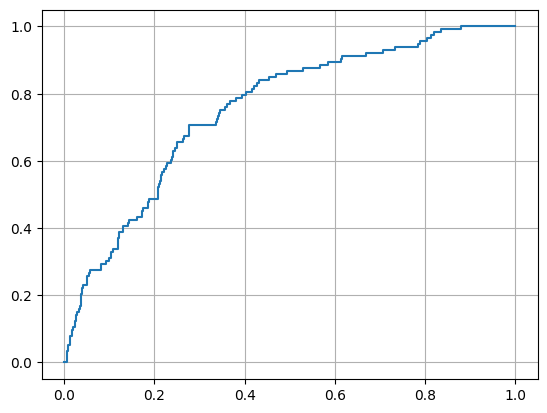

In [1070]:
plt.plot(fpr1, tpr1)
plt.grid()

Построим еще одну модель и сравним их между собой, но используем меньше параметров

In [1071]:
Xshort = X_frame.loc[ :, ['dob', 'nationality', 'sex']]
Xshort = pd.get_dummies(Xshort, columns=['nationality', 'sex'], dtype=int)
Xshort.head()

,dob,nationality_AFG,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,nationality_ANT,nationality_ARG,nationality_ARM,nationality_ARU,...,nationality_UZB,nationality_VAN,nationality_VEN,nationality_VIE,nationality_VIN,nationality_YEM,nationality_ZAM,nationality_ZIM,sex_female,sex_male
0,1969,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1986,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1992,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1991,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [1072]:
model2 = LogisticRegression(max_iter=5000)

In [1073]:
X_train_short_g, X_test_short_g, Y_train_shot_g, Y_test_short_g = train_test_split(Xshort, Y_g, test_size=0.2, random_state=42)

In [1074]:
model2.fit(X_train_short_g, Y_train_shot_g)

LogisticRegression(max_iter=5000)

In [1075]:
predictions2 = model2.predict_proba(X_test_short_g)
predictions2[:2]

array([[0.97886849, 0.02113151],
       [0.97935456, 0.02064544]])

In [1076]:
fpr2, tpr2, thres2 = roc_curve(Y_test_short_g, predictions2[:, 1], pos_label=1)

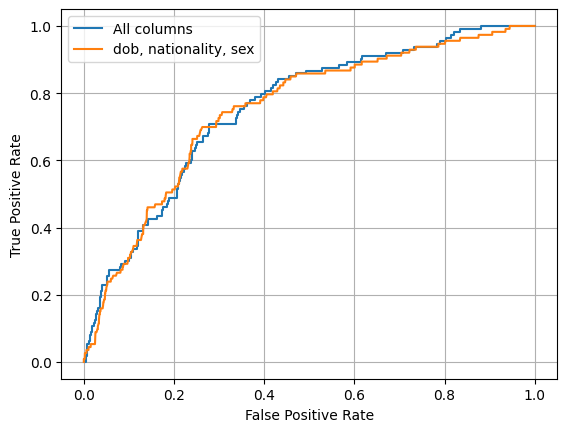

In [1077]:
plt.plot(fpr1, tpr1, label='All columns' )
plt.plot(fpr2, tpr2, label='dob, nationality, sex')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=0)
plt.grid()
plt.show()

Посчитаем площадь под кривой

In [1078]:
roc_auc_score(Y_test_g, predictions[:, 1]) # для первой модели

0.7542625297098429

In [1079]:
roc_auc_score(Y_test_g, predictions2[:, 1])

0.749745344204378

Качество второй модели немного лучше первой, на 1%

Реализуем подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn

In [1080]:
thresholds = np.linspace(0,1,200)
tpr3 = []
fpr3 = []
precisions = []
recalls = []
for th in thresholds:
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative
    predictions = model.predict_proba(X_test_g)
    for predicted_prob, actual in zip(predictions[:, 1], Y_test_g):
        if predicted_prob >= th:
            predicted = 1
        else:
            predicted = 0
    
        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
    
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    FPR = fp/(fp + tn)
    TPR = tp/(tp + fn)
    precision = tp/(tp + fp + 1e-50)
    recall = tp/(tp + fn)
    fpr3.append(FPR)
    tpr3.append(TPR)
    recalls.append(recall)
    precisions.append(precision)
    


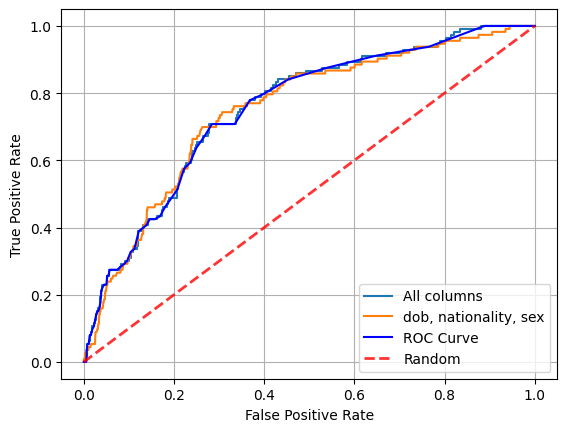

In [1081]:
plt.plot(fpr1, tpr1, label='All columns' )
plt.plot(fpr2, tpr2, label='dob, nationality, sex')
plt.plot(fpr3, tpr3, label="ROC Curve",color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=0)
plt.grid()
plt.show()

Графики построеные с помощью Sklearn и "вручную" практически одинаковы

In [1082]:
#Построим график Precision-Recall

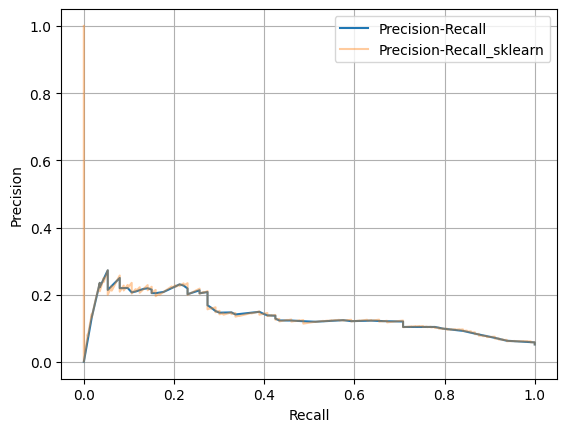

In [1083]:
plt.plot(recalls, precisions, label='Precision-Recall' )
plt.plot(recall_g, precision_g, label='Precision-Recall_sklearn' , alpha=0.4)
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc=0)
plt.grid()
plt.show()

Посчитаем метрики

In [1084]:
tp, fp, fn, tn

(0, 0, 113, 2059)

In [1085]:
# какая точность получилась?
(tp + tn) / (tp + fp + fn + tn) #

0.9479742173112339

In [1086]:
FPR = fp/(fp + tn)
FPR

0.0

In [1087]:
TPR = tp/(tp + fn)
TPR

0.0

In [1088]:
precision = tp/(tp + fp + 1e-50)
precision

0.0

In [1089]:
recall = tp/(tp + fn)
recall

0.0

Вывод: по графикам видно, что модель не сильно зависит от параметров и бинарная классификация для данного датасета не очень подходит, хотя показатели модели неплохие. Возможно стоило бы улучшить входные данные, возможно использовать другую модель, чтобы сразу три параметра(медали) учитывались с изначальной модели. ROC-кривая не может проходить ниже диагонали, т.к. это означает, что наша модель не работает и количество неправильных ответов, больше чем правильных. 